# Imports

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [35]:
# Function to load and preprocess images
def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize to 128x128
            img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return images, labels

In [36]:
root_dir = '../data/images_original'

class_folders = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

all_images = []
all_labels = []

In [37]:
# Load images and labels from each folder
for class_folder in class_folders:
    folder_path = os.path.join(root_dir, class_folder)
    images, labels = load_images_from_folder(folder_path, class_folder)
    all_images.extend(images)
    all_labels.extend(labels)

100%|██████████| 100/100 [00:00<00:00, 262.94it/s]


In [38]:
# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [39]:
df = pd.DataFrame({'image': list(all_images), 'label': all_labels})

label_counts = df['label'].value_counts()
display(Markdown("### Label Value Counts"))
display(label_counts)

# Display dataframe info
display(Markdown("### DataFrame Information"))
df_info_buffer = io.StringIO()
df.info(buf=df_info_buffer)
info = df_info_buffer.getvalue()
display(Markdown(f"```\n{info}\n```"))

### Label Value Counts

label
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: count, dtype: int64

### DataFrame Information

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   999 non-null    object
 1   label   999 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB

```

In [40]:
# Balance the dataset by ensuring each class has 99 items
balanced_df = pd.concat([df[df['label'] == label].head(99) for label in class_folders])

# Display the balanced class counts
balanced_class_counts = balanced_df['label'].value_counts()

# Use display and Markdown to format the output
display(Markdown("### Balanced Class Counts"))
display(balanced_class_counts)

### Balanced Class Counts

label
blues        99
classical    99
country      99
disco        99
hiphop       99
jazz         99
metal        99
pop          99
reggae       99
rock         99
Name: count, dtype: int64

### Sample Images from Each Class

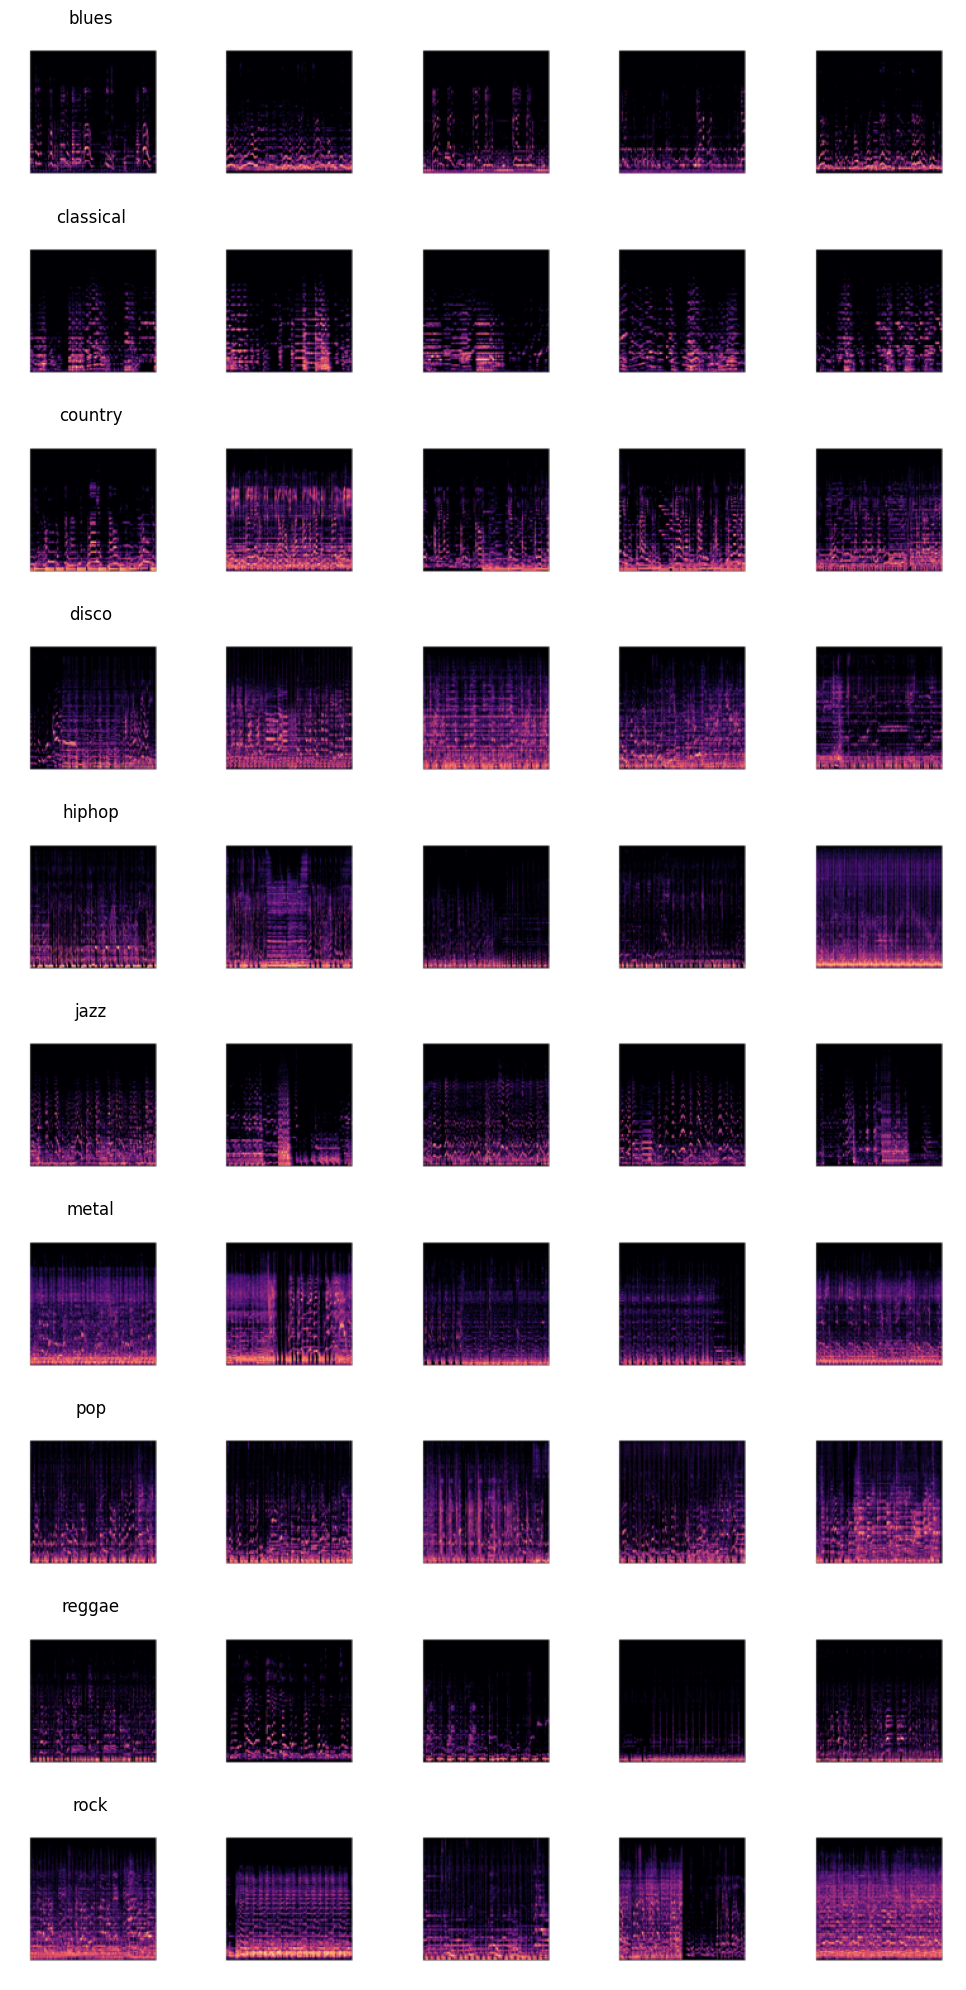

In [41]:
# Function to display images
def display_images(df, class_folders, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_folders), ncols=num_images, figsize=(num_images * 2, len(class_folders) * 2))
    for i, label in enumerate(class_folders):
        label_df = df[df['label'] == label]
        for j in range(num_images):
            img_array = label_df.iloc[j]['image']
            axes[i, j].imshow(img_array.squeeze(), cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(label)
    plt.tight_layout()
    plt.show()

# Display a few images from each class
display(Markdown("### Sample Images from Each Class"))
display_images(balanced_df, class_folders)

In [44]:
# Extract image data and labels from the DataFrame
images = np.stack(balanced_df['image'].values)
labels = balanced_df['label'].values

In [46]:
# Convert labels to categorical
label_to_index = {label: idx for idx, label in enumerate(class_folders)}
labels = np.array([label_to_index[label] for label in labels])
labels = to_categorical(labels, num_classes=len(class_folders))

In [51]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

display(Markdown("### Dataset Splits"))
display(Markdown(f"**Training set:** {X_train.shape}, {y_train.shape}"))
display(Markdown(f"**Validation set:** {X_val.shape}, {y_val.shape}"))
display(Markdown(f"**Test set:** {X_test.shape}, {y_test.shape}"))


### Dataset Splits

**Training set:** (693, 128, 128, 3, 1), (693, 10)

**Validation set:** (148, 128, 128, 3, 1), (148, 10)

**Test set:** (149, 128, 128, 3, 1), (149, 10)

In [50]:
data_dir = '../data/processed'
# Save the training data
np.save(data_dir+'/X_train.npy', X_train)
np.save(data_dir+'/y_train.npy', y_train)

# Save the validation data
np.save(data_dir+'/X_val.npy', X_val)
np.save(data_dir+'/y_val.npy', y_val)

# Save the test data
np.save(data_dir+'/X_test.npy', X_test)
np.save(data_dir+'/y_test.npy', y_test)